In [2]:
from tensorflow import keras
import numpy as np
from keras import Input as Input
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, BatchNormalization, Rescaling
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomContrast, RandomCrop
from keras.models import Sequential
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

### This can be deleted when moved out of Google Drive. This allows me to import the dataset from my google drive without pathing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/ECE_527

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ECE_527


In [4]:
data = np.load('train_data_224.npz')

In [5]:
images = data['images']
labels = data['labels']

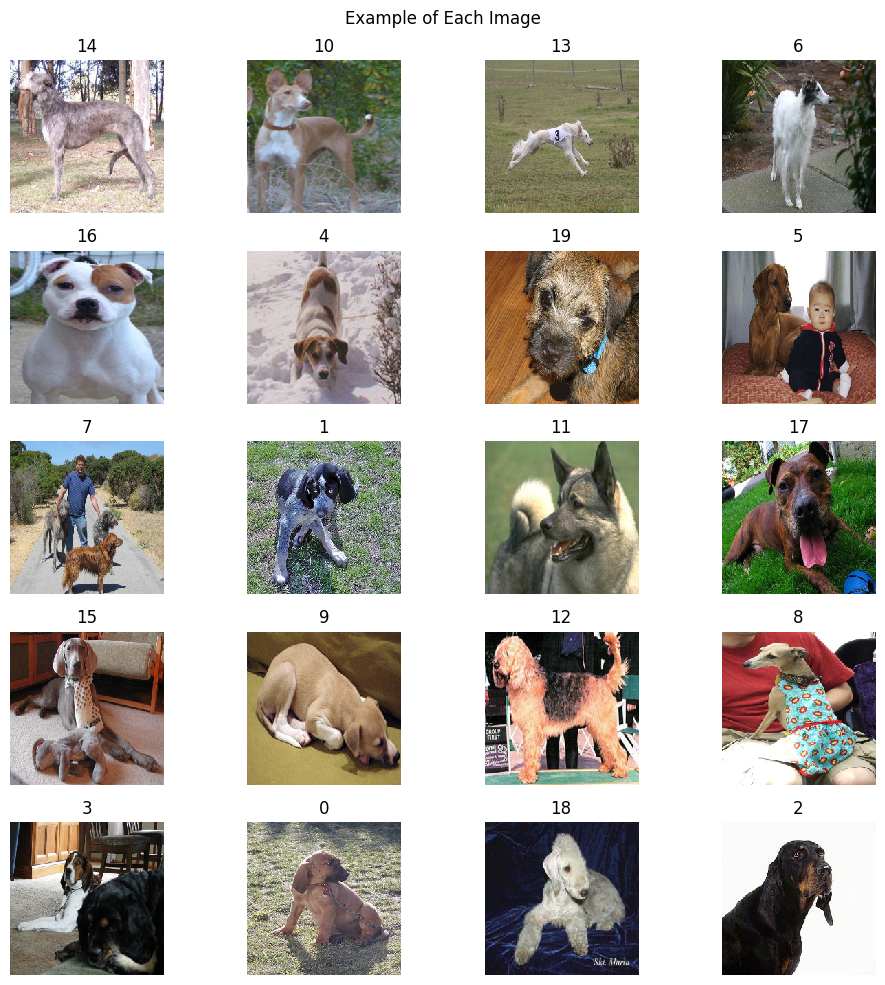

In [6]:
plotted = set()
fig, ax = plt.subplots(nrows = 5, ncols=4, figsize=(10,10))
row, col = 0, 0

for i in range(images.shape[0]):
  if labels[i] not in plotted:

    plotted.add(labels[i])
    ax[row, col].imshow(images[i], interpolation = 'nearest')
    ax[row, col].axis("off")
    ax[row, col].set_title(labels[i])
    col += 1
    if col == 4:
      row += 1
      col = 0
    if row == 5:
      break

plt.suptitle("Example of Each Image")
plt.tight_layout()
plt.savefig("image_examples.jpg")
plt.show()

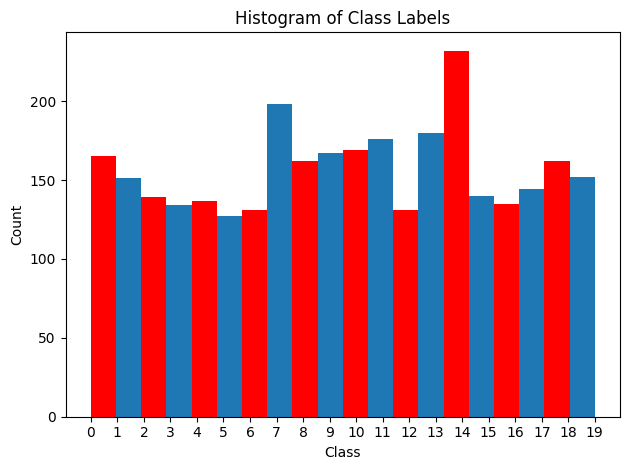

In [7]:
# unique_labels, counts = np.unique(labels, return_counts=True)
# pct_of_cnts = counts / sum(counts)
# print(pct_of_cnts)
# print(counts)
# a = np.histogram(counts)
plt.plot(figsize=(10,10))
_, _, patches = plt.hist(labels, bins=20)
for i in range(len(patches)):
  if i % 2 == 0:
    patches[i].set_facecolor('r')
# ax.locator_params(integer=True)
plt.xticks(range(0, 20, 1))
plt.title("Histogram of Class Labels")
plt.ylabel("Count")
plt.xlabel("Class")
plt.tight_layout()
plt.savefig("class_label_hist.jpg")
plt.show()

In [8]:
print(images.shape)
print(labels.shape)

(3132, 224, 224, 3)
(3132,)


### Process the labels to use categrorical cross entropy

In [9]:
# labels_encoded = to_categorical(labels)
# print(labels_encoded.shape)
# print(labels_encoded[0])

In [10]:
print(images[0].shape)
print(type(images[0]))

print(f"Red channel min: {images[0][:,:,0].min()}")
print(f"Red channel max: {images[0][:,:,0].max()}")

print(f"Green channel min: {images[0][:,:,1].min()}")
print(f"Green channel max: {images[0][:,:,1].max()}")

print(f"Blue channel min: {images[0][:,:,2].min()}")
print(f"Blue channel max: {images[0][:,:,2].max()}")

check_image = images[0] / 255

print(f"Red channel min: {check_image[:,:,0].min()}")
print(f"Red channel max: {check_image[:,:,0].max()}")

print(f"Green channel min: {check_image[:,:,1].min()}")
print(f"Green channel max: {check_image[:,:,1].max()}")

print(f"Blue channel min: {check_image[:,:,2].min()}")
print(f"Blue channel max: {check_image[:,:,2].max()}")

(224, 224, 3)
<class 'numpy.ndarray'>
Red channel min: 16
Red channel max: 255
Green channel min: 9
Green channel max: 255
Blue channel min: 17
Blue channel max: 255
Red channel min: 0.06274509803921569
Red channel max: 1.0
Green channel min: 0.03529411764705882
Green channel max: 1.0
Blue channel min: 0.06666666666666667
Blue channel max: 1.0


### Split input data, using stratify to approximately preserve the distribution of labels in the data

In [11]:
x_to_split, x_test, y_to_split, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42, stratify=labels)

x_train, x_val, y_train, y_val = train_test_split(x_to_split, y_to_split, test_size = 0.2, random_state = 42, stratify=y_to_split)

In [12]:
_, y_test_cnts = np.unique(y_test, return_counts = True)
_, y_train_cnts = np.unique(y_train, return_counts = True)
_, y_val_cnts = np.unique(y_val, return_counts = True)

all_cnts = [y_test_cnts/np.sum(y_test_cnts), y_train_cnts/np.sum(y_train_cnts), y_val_cnts/np.sum(y_val_cnts)]

all_cnts_df = pd.DataFrame(all_cnts)

print(all_cnts_df)
print(x_test.shape)
print(x_train.shape)
print(x_val.shape)

         0         1         2         3         4         5         6   \
0  0.052632  0.047847  0.044657  0.043062  0.043062  0.039872  0.041467   
1  0.052395  0.048403  0.044411  0.042914  0.043912  0.040918  0.041916   
2  0.053892  0.047904  0.043912  0.041916  0.043912  0.039920  0.041916   

         7         8         9         10        11        12        13  \
0  0.063796  0.051037  0.054226  0.054226  0.055821  0.041467  0.057416   
1  0.062874  0.051896  0.052894  0.053892  0.056387  0.041916  0.057385   
2  0.063872  0.051896  0.053892  0.053892  0.055888  0.041916  0.057884   

         14        15        16        17        18        19  
0  0.074960  0.044657  0.043062  0.046252  0.052632  0.047847  
1  0.073852  0.044910  0.042914  0.045908  0.051397  0.048902  
2  0.073852  0.043912  0.043912  0.045908  0.051896  0.047904  
(627, 224, 224, 3)
(2004, 224, 224, 3)
(501, 224, 224, 3)


### Encode label values

In [13]:
y_train_enc, y_val_enc, y_test_enc = to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)

### Convert to tensors

In [14]:
x_train_tens = tf.convert_to_tensor(x_train)
x_test_tens = tf.convert_to_tensor(x_test)
x_val_tens = tf.convert_to_tensor(x_val)

y_train_tens = tf.convert_to_tensor(y_train_enc)
y_val_tens = tf.convert_to_tensor(y_val_enc)
y_test_tens = tf.convert_to_tensor(y_test_enc)

In [15]:
print(tf.shape(x_train_tens))
print(tf.shape(y_train_tens))

tf.Tensor([2004  224  224    3], shape=(4,), dtype=int32)
tf.Tensor([2004   20], shape=(2,), dtype=int32)


### Logistic Regression as baseline approach

In [ ]:
keras.utils.set_random_seed(42)

log_reg_model = Sequential()

log_reg_model.add(Input(shape=(224, 224, 3)))

log_reg_model.add(Rescaling(scale=1./255))

log_reg_model.add(Flatten())

log_reg_model.add(keras.layers.Dense(
    20,
    activation = 'softmax',
    kernel_regularizer = 'l2'))

log_reg_model.compile(
    optimizer = keras.optimizers.SGD(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

log_reg_model.summary()

hist_log_reg_model = log_reg_model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None) #[history])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │       3,010,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,010,580 (11.48 MB)

 Trainable params: 3,010,580 (11.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.0619 - loss: 52.4170 - val_accuracy: 0.0419 - val_loss: 142.9382
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.0594 - loss: 123.1212 - val_accuracy: 0.0439 - val_loss: 99.3221
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.0589 - loss: 83.7572 - val_accuracy: 0.0559 - val_loss: 112.4611
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.0807 - loss: 104.3824 - val_accuracy: 0.0739 - val_loss: 104.3951
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.0755 - loss: 105.3588 - val_accuracy: 0.0439 - val_loss: 78.4476
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.0952 - loss: 73.4455 - val_accuracy: 0.0499 - val_loss: 75.5667
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.1265 - loss: 65.7267 - val_accuracy: 0.0818 - val_loss: 81.8561
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.1063 - loss: 80.55

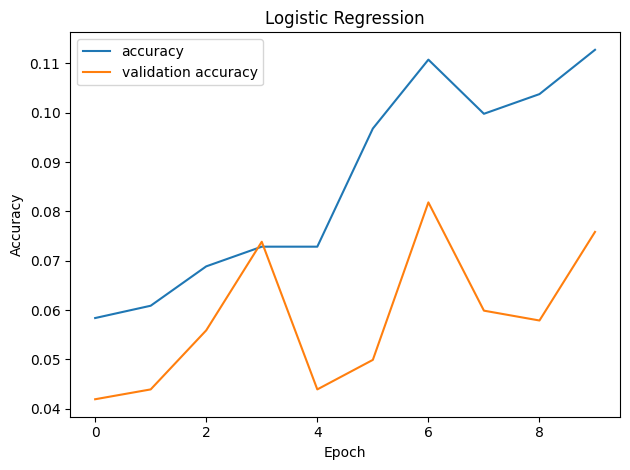

In [ ]:
acc, val_acc = hist_log_reg_model.history['accuracy'], hist_log_reg_model.history['val_accuracy']

plt.plot(acc, label="accuracy")
plt.plot(val_acc, label="validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Logistic Regression")
plt.legend()
plt.tight_layout()
plt.savefig("log_reg_acc.jpg")
plt.show()

In [ ]:
# batch size is 32

### LENET 5, RELU Activation, Adam solver, Max Pooling, Dropout
### Best performance from 8.1

keras.utils.set_random_seed(42)

model = keras.Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(scale=1./255))
model.add(Conv2D(filters=6,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=16,kernel_size=(5,5),padding='same',activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

# hist_log_reg_model = log_reg_model.fit(x_train, y_train_categorical,
model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None) #[history])

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'LeNet-5 with ReLu, Max Pooling, Dropout, Batch Size 32, Adam')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.savefig(f"lenet_5_relu_mp_drop_32_adam.jpg")
plt.show()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 112, 112, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 120)                 │       6,021,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,035,976 (23.03 MB)

 Trainable params: 6,035,976 (23.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
 7/63 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.0638 - loss: 4.9504

KeyboardInterrupt: 

# WHEN USING TRANSFER LEARNING MUST CHECK THE PREPROCESSING SPECIFICATIONS

### Base transfer learning as shown in lecture - THIS HAS INCORRECT PREPROCESSING

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_15 (RandomFlip)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_7                 │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_8 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_8 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 120)                 │      12,042,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,619,024 (135.88 MB)

 Trainable params: 12,054,224 (45.98 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 561s 35s/step - accuracy: 0.1139 - loss: 7.4238 - val_accuracy: 0.4112 - val_loss: 2.8601
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 559s 35s/step - accuracy: 0.3548 - loss: 2.8357 - val_accuracy: 0.5888 - val_loss: 1.4449
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 562s 35s/step - accuracy: 0.4495 - loss: 2.0242 - val_accuracy: 0.6866 - val_loss: 1.1106
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 512s 32s/step - accuracy: 0.5458 - loss: 1.6046 - val_accuracy: 0.7246 - val_loss: 1.0178
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 608s 35s/step - accuracy: 0.5688 - loss: 1.5051 - val_accuracy: 0.7705 - val_loss: 0.8086


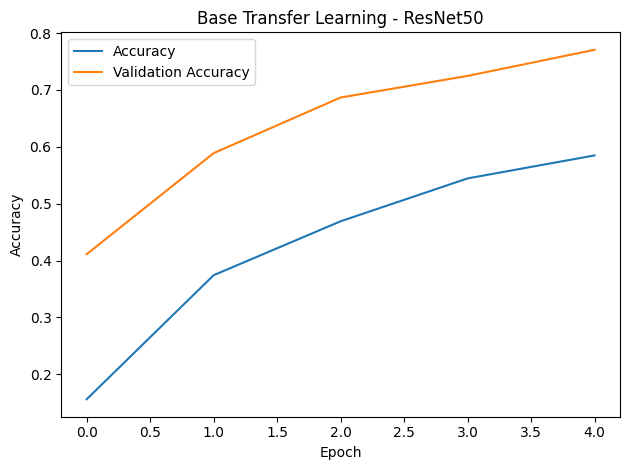

In [ ]:
base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

keras.utils.set_random_seed(42)
# base_model.summary()

model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))
model.add(RandomFlip(mode='horizontal', seed=42))
model.add(RandomTranslation(0.2, 0.2, seed=42))
model.add(RandomRotation(0.2, seed=42))
model.add(RandomZoom(0.2, seed=42))
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

# hist_log_reg_model = log_reg_model.fit(x_train, y_train_categorical,
model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None) #[history])

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'Base Transfer Learning - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.savefig(f"base_transf_res50.jpg")
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 120)                 │      12,042,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,619,024 (135.88 MB)

 Trainable params: 12,054,224 (45.98 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 570s 36s/step - accuracy: 0.0707 - loss: 8.4132 - val_accuracy: 0.2076 - val_loss: 3.9592
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 558s 35s/step - accuracy: 0.1727 - loss: 3.9463 - val_accuracy: 0.4132 - val_loss: 2.1659
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 562s 35s/step - accuracy: 0.2699 - loss: 2.7978 - val_accuracy: 0.4910 - val_loss: 1.7374
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 560s 35s/step - accuracy: 0.3254 - loss: 2.4230 - val_accuracy: 0.5609 - val_loss: 1.5600
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 511s 32s/step - accuracy: 0.3208 - loss: 2.3407 - val_accuracy: 0.5768 - val_loss: 1.4127


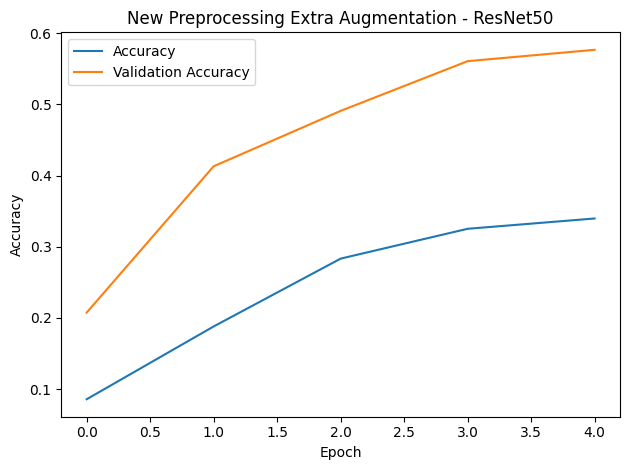

In [ ]:
base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

# x = image.img_to_array(x_train_tens[0])
# x = np.expand_dims(x, axis=0)
# x = tf.convert_to_tensor(x)
# base_model.summary()

# RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomContrast, RandomCrop

keras.utils.set_random_seed(42)

data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal", seed=42),
    RandomRotation(0.1, seed=42),
    RandomZoom(0.1, seed=42),
    RandomTranslation(0.2, 0.2, seed=42),
    RandomFlip("vertical", seed=42),
    RandomContrast(0.3, seed=42)
  ]
)


model = Sequential()
model.add(Input(shape=(224, 224, 3)))
# model.add(Rescaling(1./255))

# NOT COMPLETELY SURE WHATS GOING ON HERE
# model.add(preprocess_input())
model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, input_shape=(224, 224, 3)))


# model.add(RandomFlip(mode='horizontal'))
# model.add(RandomTranslation(0.2, 0.2))
# model.add(RandomRotation(0.2))
# model.add(RandomZoom(0.2))

model.add(data_augmentation)
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None)

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'New Preprocessing Extra Augmentation - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig(f"transf_res50_model2.jpg")
plt.show()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_18 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 120)                 │      12,042,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,619,024 (135.88 MB)

 Trainable params: 12,054,224 (45.98 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 529s 33s/step - accuracy: 0.0824 - loss: 6.4990 - val_accuracy: 0.1856 - val_loss: 2.6522
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 556s 32s/step - accuracy: 0.0825 - loss: 2.9453 - val_accuracy: 0.2655 - val_loss: 2.5281
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 558s 32s/step - accuracy: 0.1064 - loss: 2.8769 - val_accuracy: 0.3074 - val_loss: 2.3768
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 614s 36s/step - accuracy: 0.1188 - loss: 2.9276 - val_accuracy: 0.3214 - val_loss: 2.4323
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 509s 32s/step - accuracy: 0.1459 - loss: 2.8278 - val_accuracy: 0.3353 - val_loss: 2.3366


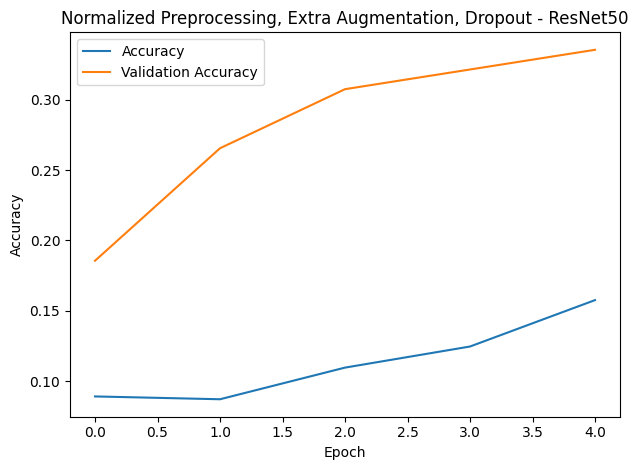

In [ ]:
base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

keras.utils.set_random_seed(42)

data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal", seed=42),
    RandomRotation(0.1, seed=42),
    RandomZoom(0.1, seed=42),
    RandomTranslation(0.2, 0.2, seed=42),
    RandomFlip("vertical", seed=42),
    RandomContrast(0.3, seed=42)
  ]
)


model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))

# NOT COMPLETELY SURE WHATS GOING ON HERE
# model.add(preprocess_input())
# model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, input_shape=(224, 224, 3)))


# model.add(RandomFlip(mode='horizontal'))
# model.add(RandomTranslation(0.2, 0.2))
# model.add(RandomRotation(0.2))
# model.add(RandomZoom(0.2))

model.add(data_augmentation)
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dropout(rate=0.25, seed=42))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dropout(rate=0.25, seed=42))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None)

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'Normalized Preprocessing, Extra Augmentation, Dropout - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig(f"transf_res50_model3.jpg")
plt.show()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_20 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 120)                 │      12,042,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,619,024 (135.88 MB)

 Trainable params: 12,054,224 (45.98 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 523s 33s/step - accuracy: 0.0940 - loss: 12.1617 - val_accuracy: 0.3892 - val_loss: 3.9444
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 606s 35s/step - accuracy: 0.2936 - loss: 4.2942 - val_accuracy: 0.5629 - val_loss: 2.0409
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 560s 35s/step - accuracy: 0.4250 - loss: 2.4649 - val_accuracy: 0.6687 - val_loss: 1.1735
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 563s 35s/step - accuracy: 0.5193 - loss: 1.8946 - val_accuracy: 0.7186 - val_loss: 1.0519
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 510s 32s/step - accuracy: 0.5507 - loss: 1.7619 - val_accuracy: 0.7166 - val_loss: 0.9741


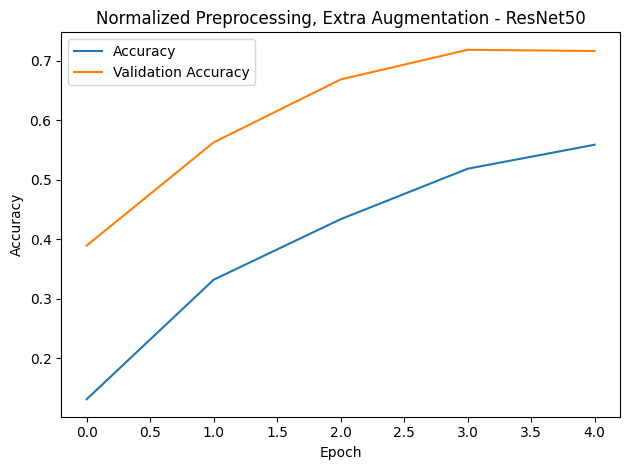

In [ ]:
base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

keras.utils.set_random_seed(42)

data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal", seed=42),
    RandomRotation(0.1, seed=42),
    RandomZoom(0.1, seed=42),
    RandomTranslation(0.2, 0.2, seed=42),
    RandomFlip("vertical", seed=42),
    RandomContrast(0.3, seed=42)
  ]
)


model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))

# NOT COMPLETELY SURE WHATS GOING ON HERE
# model.add(preprocess_input())
# model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, input_shape=(224, 224, 3)))


# model.add(RandomFlip(mode='horizontal'))
# model.add(RandomTranslation(0.2, 0.2))
# model.add(RandomRotation(0.2))
# model.add(RandomZoom(0.2))

model.add(data_augmentation)
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None)

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'Normalized Preprocessing, Extra Augmentation - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig(f"transf_res50_model4.jpg")
plt.show()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │      12,042,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,619,024 (135.88 MB)

 Trainable params: 12,054,224 (45.98 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 613s 38s/step - accuracy: 0.0848 - loss: 9.8891 - val_accuracy: 0.3553 - val_loss: 3.9686
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 627s 39s/step - accuracy: 0.3053 - loss: 4.1049 - val_accuracy: 0.5429 - val_loss: 1.8891
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 578s 37s/step - accuracy: 0.4338 - loss: 2.6273 - val_accuracy: 0.6367 - val_loss: 1.3620
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 641s 38s/step - accuracy: 0.4670 - loss: 2.1010 - val_accuracy: 0.6826 - val_loss: 1.0495
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 581s 37s/step - accuracy: 0.5199 - loss: 1.8479 - val_accuracy: 0.7046 - val_loss: 0.9835


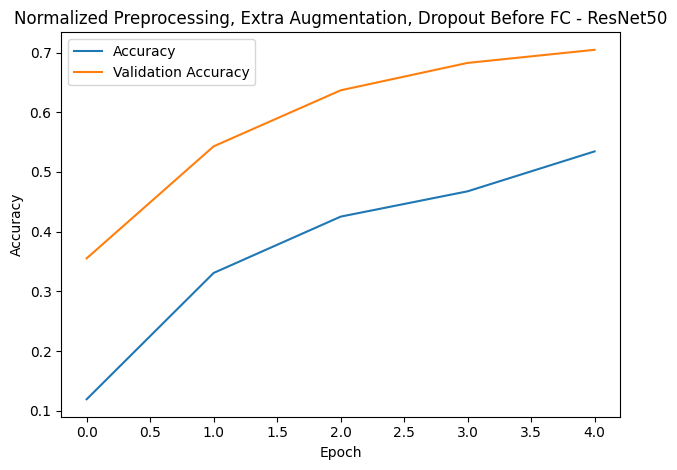

In [16]:
base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

keras.utils.set_random_seed(42)

# data_augmentation = keras.Sequential(
#   [
#     RandomFlip("horizontal", seed=42),
#     RandomRotation(0.1, seed=42),
#     RandomZoom(0.1, seed=42),
#     RandomTranslation(0.2, 0.2, seed=42),
#     RandomFlip("vertical", seed=42),
#     RandomContrast(0.3, seed=42)
#   ]
# )


model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))

# NOT COMPLETELY SURE WHATS GOING ON HERE
# model.add(preprocess_input())
# model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, input_shape=(224, 224, 3)))


# model.add(RandomFlip(mode='horizontal'))
# model.add(RandomTranslation(0.2, 0.2))
# model.add(RandomRotation(0.2))
# model.add(RandomZoom(0.2))

model.add(RandomFlip("horizontal", seed=42))
model.add(RandomRotation(0.1, seed=42))
model.add(RandomZoom(0.1, seed=42))
model.add(RandomTranslation(0.2, 0.2, seed=42))
model.add(RandomFlip("vertical", seed=42))
model.add(RandomContrast(0.3, seed=42))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(rate=0.5, seed=42))
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None)

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'Normalized Preprocessing, Extra Augmentation, Dropout Before FC - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig(f"transf_res50_model5.jpg")
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_2 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_1                 │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 120)                 │      12,042,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,619,024 (135.88 MB)

 Trainable params: 12,054,224 (45.98 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 588s 37s/step - accuracy: 0.1157 - loss: 8.1360 - val_accuracy: 0.5090 - val_loss: 2.6974
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 566s 33s/step - accuracy: 0.4560 - loss: 2.8587 - val_accuracy: 0.6567 - val_loss: 1.7149
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 558s 33s/step - accuracy: 0.5380 - loss: 2.0102 - val_accuracy: 0.7066 - val_loss: 1.0819
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 615s 36s/step - accuracy: 0.6095 - loss: 1.5243 - val_accuracy: 0.7305 - val_loss: 1.0139
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 588s 34s/step - accuracy: 0.6190 - loss: 1.3935 - val_accuracy: 0.7305 - val_loss: 0.9441


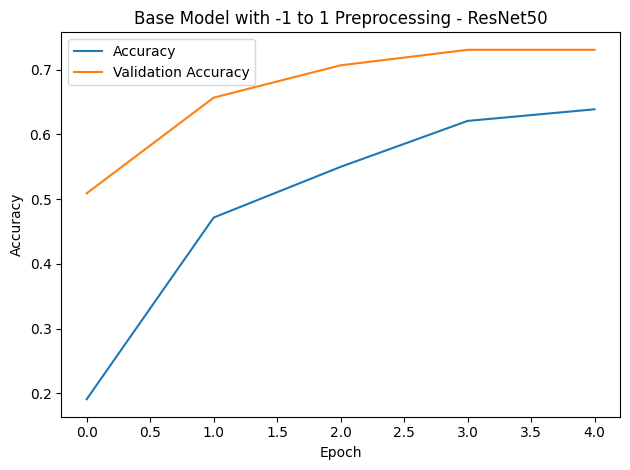

In [17]:
base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

keras.utils.set_random_seed(42)

# data_augmentation = keras.Sequential(
#   [
#     RandomFlip("horizontal", seed=42),
#     RandomRotation(0.1, seed=42),
#     RandomZoom(0.1, seed=42),
#     RandomTranslation(0.2, 0.2, seed=42),
#     RandomFlip("vertical", seed=42),
#     RandomContrast(0.3, seed=42)
#   ]
# )


model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(scale=1./127.5, offset=-1.))

# NOT COMPLETELY SURE WHATS GOING ON HERE
# model.add(preprocess_input())
# model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, input_shape=(224, 224, 3)))


# model.add(RandomFlip(mode='horizontal'))
# model.add(RandomTranslation(0.2, 0.2))
# model.add(RandomRotation(0.2))
# model.add(RandomZoom(0.2))

# model.add(RandomFlip("horizontal", seed=42))
# model.add(RandomRotation(0.1, seed=42))
# model.add(RandomZoom(0.1, seed=42))
# model.add(RandomTranslation(0.2, 0.2, seed=42))
# model.add(RandomFlip("vertical", seed=42))
# model.add(RandomContrast(0.3, seed=42))
model.add(RandomFlip(mode='horizontal', seed=42))
model.add(RandomTranslation(0.2, 0.2, seed=42))
model.add(RandomRotation(0.2, seed=42))
model.add(RandomZoom(0.2, seed=42))
model.add(base_model)
model.add(Flatten())
# model.add(Dropout(rate=0.5, seed=42))
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None)

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'Base Model with -1 to 1 Preprocessing - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig(f"transf_res50_model6.jpg")
plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_3 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_2                 │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 120)                 │      12,042,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,619,024 (135.88 MB)

 Trainable params: 12,054,224 (45.98 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 603s 38s/step - accuracy: 0.1434 - loss: 5.7063 - val_accuracy: 0.5150 - val_loss: 1.7466
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 601s 36s/step - accuracy: 0.4346 - loss: 2.2405 - val_accuracy: 0.6367 - val_loss: 1.1732
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 574s 33s/step - accuracy: 0.5039 - loss: 1.7250 - val_accuracy: 0.6926 - val_loss: 0.9353
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 610s 36s/step - accuracy: 0.5743 - loss: 1.4288 - val_accuracy: 0.7565 - val_loss: 0.8100
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 634s 37s/step - accuracy: 0.6186 - loss: 1.3183 - val_accuracy: 0.7605 - val_loss: 0.7782


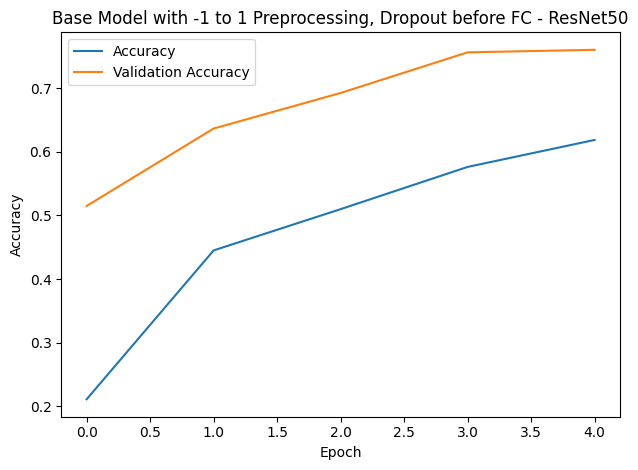

In [18]:
base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

keras.utils.set_random_seed(42)

# data_augmentation = keras.Sequential(
#   [
#     RandomFlip("horizontal", seed=42),
#     RandomRotation(0.1, seed=42),
#     RandomZoom(0.1, seed=42),
#     RandomTranslation(0.2, 0.2, seed=42),
#     RandomFlip("vertical", seed=42),
#     RandomContrast(0.3, seed=42)
#   ]
# )


model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(scale=1./127.5, offset=-1.))

# NOT COMPLETELY SURE WHATS GOING ON HERE
# model.add(preprocess_input())
# model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, input_shape=(224, 224, 3)))


# model.add(RandomFlip(mode='horizontal'))
# model.add(RandomTranslation(0.2, 0.2))
# model.add(RandomRotation(0.2))
# model.add(RandomZoom(0.2))

# model.add(RandomFlip("horizontal", seed=42))
# model.add(RandomRotation(0.1, seed=42))
# model.add(RandomZoom(0.1, seed=42))
# model.add(RandomTranslation(0.2, 0.2, seed=42))
# model.add(RandomFlip("vertical", seed=42))
# model.add(RandomContrast(0.3, seed=42))
model.add(RandomFlip(mode='horizontal', seed=42))
model.add(RandomTranslation(0.2, 0.2, seed=42))
model.add(RandomRotation(0.2, seed=42))
model.add(RandomZoom(0.2, seed=42))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(rate=0.5, seed=42))
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None)

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'Base Model with -1 to 1 Preprocessing, Dropout before FC - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig(f"transf_res50_model7.jpg")
plt.show()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_4 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_3                 │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_5 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 120)                 │      12,042,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,619,024 (135.88 MB)

 Trainable params: 12,054,224 (45.98 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 592s 37s/step - accuracy: 0.0757 - loss: 6.8098 - val_accuracy: 0.2914 - val_loss: 3.3655
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 577s 37s/step - accuracy: 0.2007 - loss: 3.5932 - val_accuracy: 0.4571 - val_loss: 2.2549
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 589s 37s/step - accuracy: 0.2592 - loss: 2.8714 - val_accuracy: 0.5110 - val_loss: 1.9141
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 610s 37s/step - accuracy: 0.2793 - loss: 2.5665 - val_accuracy: 0.5489 - val_loss: 1.5450
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 621s 36s/step - accuracy: 0.3098 - loss: 2.4341 - val_accuracy: 0.5709 - val_loss: 1.4342


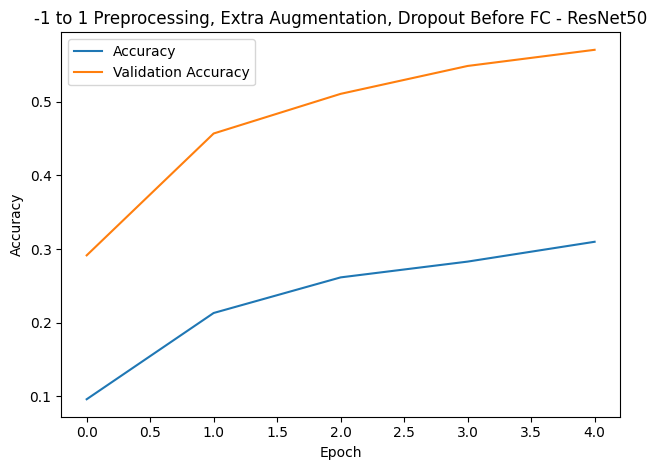

In [19]:
base_model = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

keras.utils.set_random_seed(42)

# data_augmentation = keras.Sequential(
#   [
#     RandomFlip("horizontal", seed=42),
#     RandomRotation(0.1, seed=42),
#     RandomZoom(0.1, seed=42),
#     RandomTranslation(0.2, 0.2, seed=42),
#     RandomFlip("vertical", seed=42),
#     RandomContrast(0.3, seed=42)
#   ]
# )


model = Sequential()
model.add(Input(shape=(224, 224, 3)))
# model.add(Rescaling(1./255))
model.add(Rescaling(scale=1./127.5, offset=-1.))
model.add(RandomFlip("horizontal", seed=42))
model.add(RandomRotation(0.1, seed=42))
model.add(RandomZoom(0.1, seed=42))
model.add(RandomTranslation(0.2, 0.2, seed=42))
model.add(RandomFlip("vertical", seed=42))
model.add(RandomContrast(0.3, seed=42))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(rate=0.5, seed=42))
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None)

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'-1 to 1 Preprocessing, Extra Augmentation, Dropout Before FC - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig(f"transf_res50_model8.jpg")
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 7, 7, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │       7,526,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,869,744 (106.31 MB)

 Trainable params: 7,538,384 (28.76 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 676s 41s/step - accuracy: 0.3509 - loss: 2.3312 - val_accuracy: 0.8962 - val_loss: 0.3378
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 722s 43s/step - accuracy: 0.7115 - loss: 1.0931 - val_accuracy: 0.8942 - val_loss: 0.3083
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 719s 42s/step - accuracy: 0.7178 - loss: 1.0129 - val_accuracy: 0.8703 - val_loss: 0.3469
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 659s 40s/step - accuracy: 0.7427 - loss: 0.8753 - val_accuracy: 0.9082 - val_loss: 0.2665
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 706s 42s/step - accuracy: 0.7562 - loss: 0.8778 - val_accuracy: 0.9102 - val_loss: 0.3266


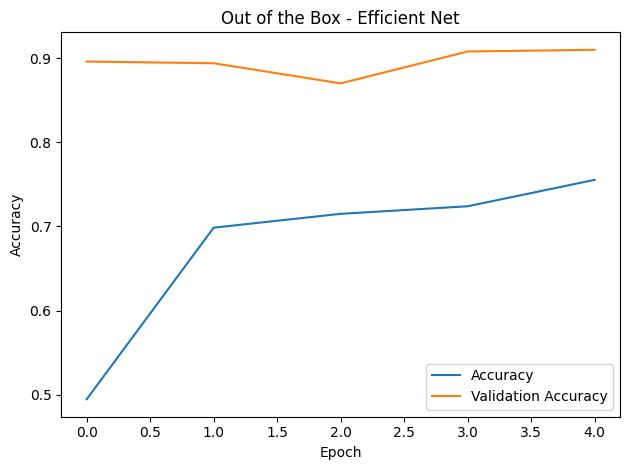

In [16]:
### Try out of the box Efficient Net

from tensorflow.keras.applications import EfficientNetV2S

eff_net = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_preprocessing=True
)

eff_net.trainable = False

keras.utils.set_random_seed(42)

model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(RandomFlip("horizontal", seed=42))
model.add(RandomRotation(0.1, seed=42))
model.add(RandomZoom(0.1, seed=42))
model.add(RandomTranslation(0.2, 0.2, seed=42))
model.add(RandomFlip("vertical", seed=42))
model.add(RandomContrast(0.3, seed=42))
model.add(eff_net)
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None)

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'Out of the Box - Efficient Net')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig(f"transf_eff_net_model1.jpg")
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_1                 │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_3 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 7, 7, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 120)                 │       7,526,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │           1,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,869,744 (106.31 MB)

 Trainable params: 7,538,384 (28.76 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 672s 41s/step - accuracy: 0.3582 - loss: 2.2780 - val_accuracy: 0.8623 - val_loss: 0.4384
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 677s 40s/step - accuracy: 0.7113 - loss: 0.9978 - val_accuracy: 0.8822 - val_loss: 0.2943
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 702s 42s/step - accuracy: 0.7108 - loss: 0.9732 - val_accuracy: 0.8842 - val_loss: 0.3149
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 664s 40s/step - accuracy: 0.7552 - loss: 0.8133 - val_accuracy: 0.9162 - val_loss: 0.2732
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 698s 41s/step - accuracy: 0.7535 - loss: 0.8042 - val_accuracy: 0.9042 - val_loss: 0.2842


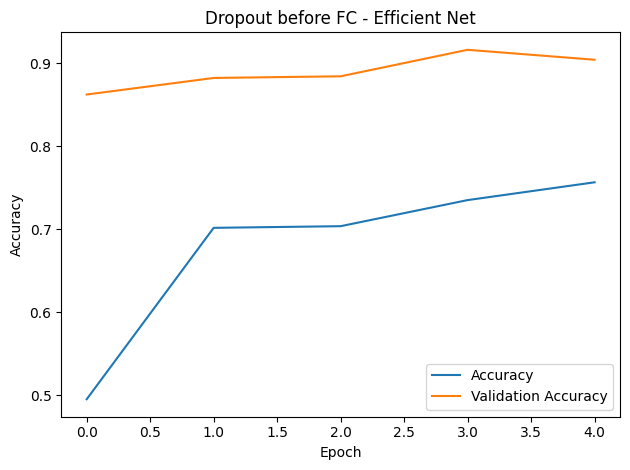

In [17]:
from tensorflow.keras.applications import EfficientNetV2S

eff_net = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_preprocessing=True
)

eff_net.trainable = False

keras.utils.set_random_seed(42)

model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(RandomFlip("horizontal", seed=42))
model.add(RandomRotation(0.1, seed=42))
model.add(RandomZoom(0.1, seed=42))
model.add(RandomTranslation(0.2, 0.2, seed=42))
model.add(RandomFlip("vertical", seed=42))
model.add(RandomContrast(0.3, seed=42))
model.add(eff_net)
model.add(Flatten())
model.add(Dropout(rate=0.5, seed=42))
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation= 'relu'))
model.add(Dense(units=20, activation ='softmax'))

model.compile(
    optimizer = keras.optimizers.Adam(),
    # loss = keras.losses.categorical_crossentropy,
    loss = keras.losses.CategoricalCrossentropy,
    metrics = ['accuracy']
)

model.summary()

model_hist = model.fit(x_train_tens, y_train_tens,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data = (x_val_tens, y_val_tens),
          callbacks=None)

plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.title(f'Dropout before FC - Efficient Net')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig(f"transf_eff_net_model2.jpg")
plt.show()